# Section 1 <small>of Assignment 2</small> 

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *

'''
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)
'''

# Define
Tx = 5511
n_freq = 101
Ty = 1375 # the length of labels


# Load audio segments using pydub
activates, negatives, backgrounds = load_raw_audio()

print('background len: ' + str(len(backgrounds[0])))
print('activate[0] len: ' + str(len(activates[0])))
print('activate[1] len: ' + str(len(activates[1])))


def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    # Make sure segment doesn't run past the 10sec background 
    segment_start = np.random.randint(low=0, high=10000-segment_ms)
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)


/home/li/.local/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


background len: 10000
activate[0] len: 1741
activate[1] len: 655


In [2]:
def is_overlapping(seg_time, prev_segs):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    start, end = seg_time
    flag = False
    for (prev_start, prev_end) in prev_segs:
        flag = flag or not (end < prev_start or start > prev_end)
    return flag


In [3]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [11]:
def __insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    audio_ms = len(audio_clip)
    
    # while True:
    #    segment_time = get_random_time_segment(audio_ms)
    #    if not is_overlapping(segment_time, previous_segments):
    #        break
    segment_time = get_random_time_segment(audio_ms)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(audio_ms)

    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position = segment_time[0])
    return new_background, segment_time



def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    audio_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(audio_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(audio_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [23]:
np.random.seed(0)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (4859, 6599)


In [7]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """

    # y is a numpy array instead of a python list
    end_y = int(segment_end_ms * Ty / 10000)
    y[0, (end_y+1):(end_y + 51)] = 1 
    # notice the meaning of "strictly after".
    return y

sanity checks: 0.0 1.0 0.0


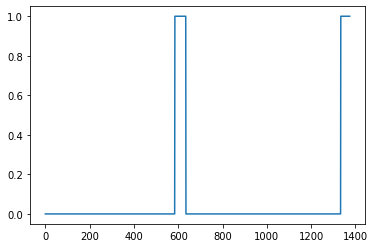

In [8]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [29]:
def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
        
    np.random.seed(8)            # Set the random seed
    background = background - 20  # Make background quieter
    
    y = np.zeros((1, Ty))
    prev_segments = []

    # Overlay activate segments to background 
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for acti in random_activates:
        background, segment_time = insert_audio_clip(background, acti, prev_segments)
        _, segment_end = segment_time
        y = insert_ones(y, segment_end)

    # Overlay negatives segments to background 
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for nega in random_negatives:
        background, _ = insert_audio_clip(background, nega, [])

    ### Post-process ###

    # Standardize the volume of the audio clip
    background = match_target_amplitude(background, -20.0)

    # Export new training example
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")

    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")

    return x, y

File (train.wav) was saved in your directory.


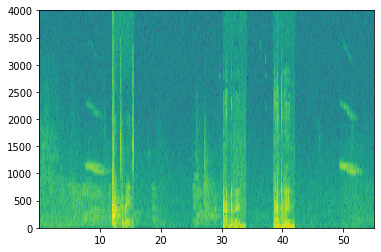

In [30]:
np.random.seed(6)
x, y = create_training_example(backgrounds[0], activates, negatives)

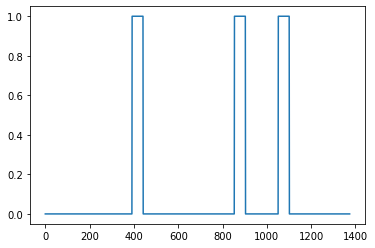

In [31]:
plt.plot(y[0])